# Integrating lung datasets using EmbedMNN model

In this example, we will use *transmorph* to integrate lung datasets from three patients, gathered in [1]. These datasets contain in total more than 60k cells, which are all associated with a compartment annotation: *immune*, *stromal*, *endothelial* and *epithelial*. As cells show high transcriptomic differences between these compartments, we consider the integration of these datasets to be an "easy" task, compared to cases with many more, and more subtle cell types. We are interested in identifying subclusters in these compartments to identify cell subtypes.

We use one of our built-in models, **EmbedMNN**, to carry out the integration. It combines a few preprocessing steps (common genes space embedding, normalization and dimensionality reduction) with a mutual nearest neighbors (MNN)-based matching [2] and a low-dimensional space embedding using UMAP [3] or MDE [4]. This low dimensional space can subsequently be used to carry out tasks such as clustering.

### Loading the data bank

*transmorph* provides a few data banks for testing purposes, already preprocessed (cell/gene filtering, normalization, log1p...) and annotated. They can be loaded using *datasets* module. Lung databank contains three datasets in the AnnData format, each expressed in its 10,000 most variable genes space. Cells are annotated by the .obs key "class". If the queried databank is missing, it will be automatically downloaded, and saved locally for faster subsequent access.

In [1]:
from transmorph.datasets import load_travaglini_10x

# Format: {patient_label -> AnnData}
trav_10x = load_travaglini_10x()

databank_api > Loading bank travaglini_10x.
databank_api > Bank travaglini_10x successfully loaded.


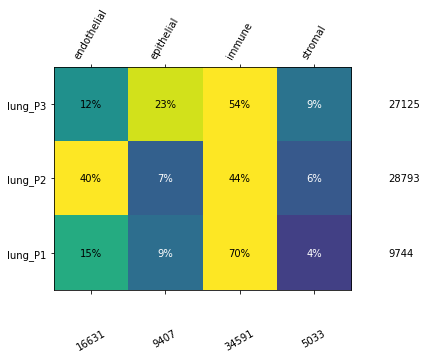

In [3]:
from transmorph.utils.plotting import plot_label_distribution_heatmap

plot_label_distribution_heatmap(trav_10x, label="class")

### Plotting initial datasets using scatter_plot

The scatter_plot method can be used to display a low dimensional representation of a set of datasets. It will automatically use a *transmorph* integrated representation if present in all AnnData objects. If this integrated representation is missing, it will try to compute a UMAP of .X matrices. Computing this UMAP representation can take some time for large datasets, but it can then be cached to avoid recomputing every time.

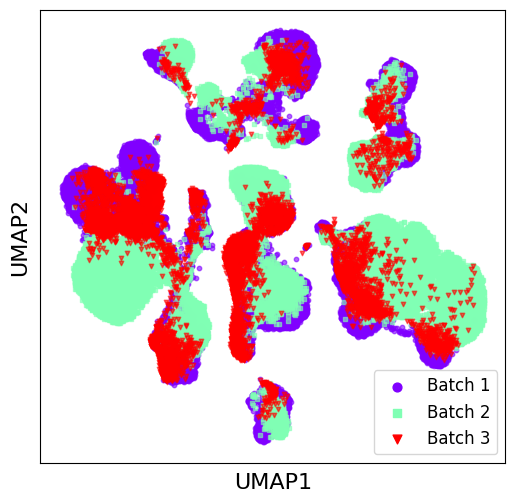

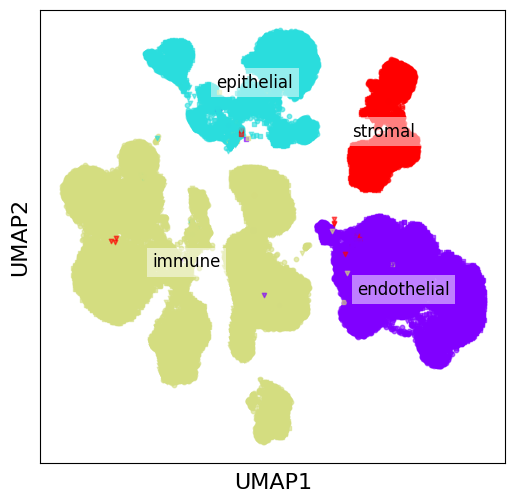

In [14]:
from transmorph.utils.plotting import scatter_plot, reduce_dimension

reduce_dimension(datasets, output_obsm="before_transmorph")

# use_cache=True allows to avoid recomputing a UMAP representation for each plot
scatter_plot(
    datasets, 
    input_obsm="before_transmorph"
)
scatter_plot(
    datasets, 
    color_by="class", 
    plot_cluster_names=True, 
    show_legend=False, 
    input_obsm="before_transmorph"
)

We can see here why we claim this is an "easy" databank to integrate. Differences between compartments are so important that compartments are already clustered in initial gene space. Though, we observe clear patient-dependent subclusters in these compartment clusters, which can cause issue when trying to identify biologically-relevant subpopulations.

### Dataset integration using EmbedMNN

**EmbedMNN** combines a mutual nearest neighbors step and a low-dimensional embedding, here using UMAP. Parameters can be tuned during model instanciation. Model can then be ran using transform() method, providing a list of AnnData objects. It will add a .obsm["transmorph"] entry, corresponding to the integrated view computed.
**This model starts by embedding all datasets in a common genes space, therefore there must exists a nonempty intersection between all .var_names.**

In [2]:
from transmorph.models import MNNCorrection

# Using these two parameters, we can tune the balance
# between matching edges and knn edges.
model = MNNCorrection() 
model.transform(trav_10x, reference=trav_10x['lung_P3'])

MNN_CORRECTION > Transmorph model is initializing.
MNN_CORRECTION > Ready to start the integration of 3 datasets, 65662 total samples.
MNN_CORRECTION > Running layer LAYER_INPUT#0.
MNN_CORRECTION > Running layer LAYER_TRANSFORMATION#1.
MNN_CORRECTION > Running layer LAYER_TRANSFORMATION#2.
MNN_CORRECTION > Running layer LAYER_MATCHING#3.
LAYER_MATCHING#3 > Calling matching MATCHING_MNN.
MNN_CORRECTION > Running layer LAYER_MERGING#4.
LAYER_MERGING#4 > Running merging MERGING_LINEAR_CORRECTION...
MNN_CORRECTION > Running layer LAYER_OUTPUT#5.
MNN_CORRECTION > Terminated. Total embedding shape: (65662, 6335)
MNN_CORRECTION > Results have been written in AnnData.obsm['transmorph'].


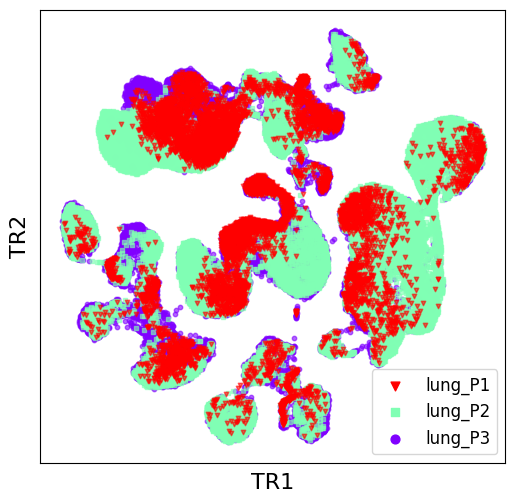

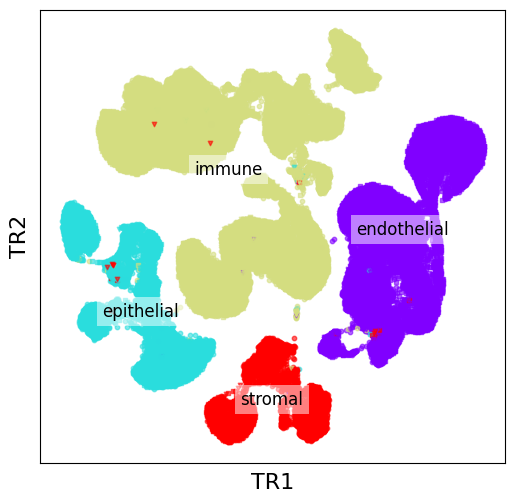

In [10]:
from transmorph.utils.plotting import reduce_dimension, scatter_plot

reduce_dimension(trav_10x, reducer="umap", input_obsm="transmorph")

scatter_plot(trav_10x, xlabel="TR1", ylabel="TR2")
scatter_plot(
    trav_10x, color_by="class", show_legend=False, 
    plot_cluster_names=True, xlabel="TR1", ylabel="TR2"
)

As we can see, **EmbedMNN** has improved separation between compartment-based clusters, and emphasized a better resolved, sub-clustered structure. We have now to assess quantitively that datasets are better merged, and we can doing so using Local Inverse Simpson Index (LISI).

### Comparing dataset homogeneity using LISI

Local Inverse Simpson Index (LISI) is a statistic introduced in the integration algorithm Harmony [5] that measures the source heterogenity of a sample neighborhood in a joint embedding. The higher, the more diverse datasets are in a point's neighborhood, suggesting better dataset integration. *transmorph* contains its implementation of LISI, and we can use it to assess integration quality.

In [11]:
import numpy as np

from transmorph.stats.lisi import compute_lisi

In [16]:
datasets = list(trav_10x.values())
Xs_before = np.concatenate([adata.obsm['before_transmorph'] for adata in datasets], axis=0)
Xs_after = np.concatenate([adata.obsm['transmorph'] for adata in datasets], axis=0)
labels = np.array(sum([[i]*adata.n_obs for i, adata in enumerate(datasets)], []))

lisi_before = compute_lisi(Xs_before, labels)
lisi_after = compute_lisi(Xs_after, labels)
print(
    f"LISI before - min: {lisi_before.min()}, max: {lisi_before.max()}, "
    f"mean: {lisi_before.mean()}, median: {np.median(lisi_before)}"
)
print(
    f"LISI after - min: {lisi_after.min()}, max: {lisi_after.max()}, "
    f"mean: {lisi_after.mean()}, median: {np.median(lisi_after)}"
)

LISI before - min: 1.0, max: 2.999999761581421, mean: 1.3740954399108887, median: 1.142132043838501
LISI after - min: 1.0, max: 2.999999761581421, mean: 1.4585227966308594, median: 1.2461538314819336


As we can see, performing the integration step using **EmbedMNN** greatly increased mean and median LISI score, from an average of 1.3 datasets per sample neighborhood to around 1.8 datasets per sample neighborhood.